<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-04-10 06:53:45--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.207, 173.194.213.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  79.0MB/s    in 1.1s    

2024-04-10 06:53:46 (79.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Initialize the base model
# Set the input shape and remove the dense layer
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape : ',last_layer.output_shape)
last_output = last_layer.output

Last layer output shape :  (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation = 'relu')(x)
# Add Dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1,activation = 'sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input,x)

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [6]:
model.compile(optimizer = RMSprop(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [7]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2024-04-10 06:54:15--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   133MB/s    in 0.5s    

2024-04-10 06:54:16 (133 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile('./cats_and_dogs_filtered.zip','r')
zip_ref.extractall('tmp/')
zip_ref.close()

# Define directoy
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

# Directory with training cats and dogs examples
train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

# Directory with validation cats and dogs examples
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_cats_dir = os.path.join(validation_dir,'dogs')

# Add data augmentation parameters to the ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150,150))

# Flow the validation image in batches of 20 using teat_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        target_size = (150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    validation_steps = 50,
                    verbose = 1)

Epoch 1/20
100/100 [==============================] - 216s 2s/step - loss: 0.3472 - accuracy: 0.8585 - val_loss: 0.1904 - val_accuracy: 0.9210
Epoch 2/20
100/100 [==============================] - 218s 2s/step - loss: 0.1961 - accuracy: 0.9170 - val_loss: 0.0998 - val_accuracy: 0.9590
Epoch 3/20
100/100 [==============================] - 208s 2s/step - loss: 0.1915 - accuracy: 0.9300 - val_loss: 0.0920 - val_accuracy: 0.9590
Epoch 4/20
100/100 [==============================] - 246s 2s/step - loss: 0.1802 - accuracy: 0.9360 - val_loss: 0.1079 - val_accuracy: 0.9600
Epoch 5/20
100/100 [==============================] - 218s 2s/step - loss: 0.1829 - accuracy: 0.9315 - val_loss: 0.1404 - val_accuracy: 0.9490
Epoch 6/20
100/100 [==============================] - 205s 2s/step - loss: 0.1377 - accuracy: 0.9465 - val_loss: 0.1098 - val_accuracy: 0.9650
Epoch 7/20
100/100 [==============================] - 247s 2s/step - loss: 0.1329 - accuracy: 0.9405 - val_loss: 0.1411 - val_accuracy: 0.9550

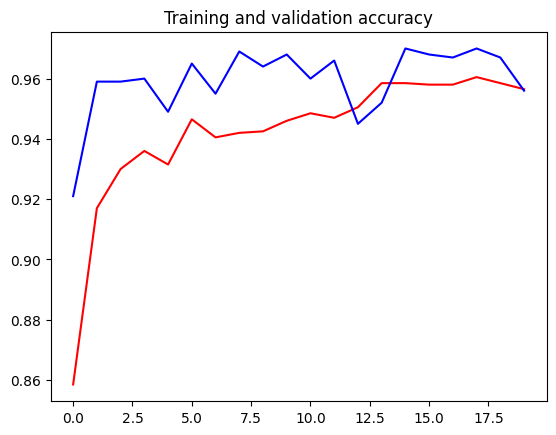

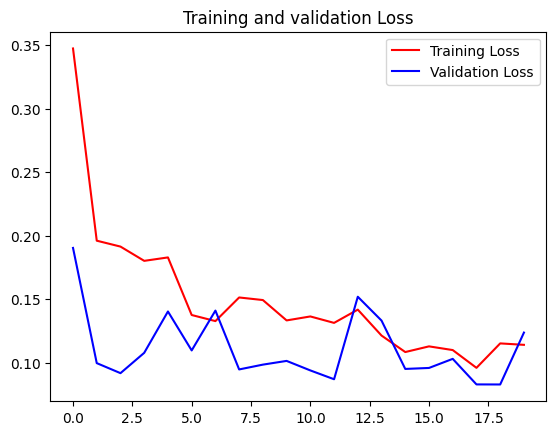

In [10]:
# Evaluate the result
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs =range(len(acc))

plt.plot(epochs,acc,'r',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs,loss,'r',label = 'Training Loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)

plt.show()